In [1]:
import psycopg2
import json
import pathlib
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")


CONFIGURATION_FILE = pathlib.Path('../../secrets/dontdothis/please/ok/secrets.json')

In [2]:
def open_db():
    with open(CONFIGURATION_FILE, 'r') as file:
        config = json.load(file)
    connection = psycopg2.connect(
        host=config['HOST'],
        user=config['USER'],
        password=config['PASSWORD'],
        dbname=config['DATABASE']
    )
    return connection


def count_items(connection):
    cur = connection.cursor()
    cur.execute('''
                    SELECT count(*) FROM items;
                ''')
    amount_of_items = cur.fetchall()
    connection.commit()
    return amount_of_items[0][0]


def make_query(connection, query):
    cur = connection.cursor()
    cur.execute(query)
    response = cur.fetchall()
    connection.commit()
    return response


def select_apartments(connection, limit, offset):
    cur = connection.cursor()
    cur.execute(f'''
                    SELECT * FROM items order by publishing_date DESC limit {limit} offset {offset};
                ''')
    response = cur.fetchall()
    connection.commit()
    cur.close()
    connection.close()
    return response


def main_statistics(connection, column):
    cur = connection.cursor()
    cur.execute(f'''
                    select avg({column}), max({column}), min({column}), stddev({column})  from items;
                ''')
    response = cur.fetchone()
    connection.commit()
    return {'average': response[0],
            'maximum': response[1],
            'minimum': response[2],
            'std': response[3]}


In [3]:
# preprocessing is based on an analysis which is located several cells below

def preprop_city(x):
    x = " ".join(x.split(" ")[-2:])
    if x == 'в Киеве':
        return 2
    elif x in  ['в Днепропетровске', 'в Одессе', 'в Житомире', 'в Львове', 'в Харькове']: 
        return 1
    else:
        return 0
    
def preprop_regions(x):
    if x == 'Печерский':
        return 5
    elif x in  ['Шевченковский', 'Оболонский', 'Подольский', 'Голосеевский']: 
        return 4
    elif x in ['Приморский', 'Днепровский', 'Соломенский', 'Дарницкий', 'Подолье','Святошинский', 'Центр']:
        return 3
    elif x in ['Деснянский','Таирова', 'Славянка', 'Киевский', 'Салтовка','Софиевская Борщаговка', 'Малиновский', 
               'Вишенка', 'Ближнее замостье', 'Свердловский массив','Суворовский']:
        return 2
    elif x in ['Одесская', 'Ирпень', 'Замостье', 'Выставка', 'Старый город']:
        return 1
    else:
        return 0
    
def preprop_type_sentence(x):
    if x in ['от посредника', 'от застройщика', 'от представителя застройщика']:
        return x
    elif x in  ['от собственника', 'от представителя хозяина (без комиссионных)']: 
        return 'от хозяина'
    else:
        return 'от непятно кого'
#         raise Exception( 'I dont understand your type_of_sentence')

def preprop_walls(x):
    if x in ['монолитный железобетон', 'монолит', 'железобетон']:
        return 4
    elif x == 'кирпич':
        return 3
    elif x == 'панель':
        return 2
    elif x in  ['керамзитобетон', 'ракушечник (ракушняк)', 'монолитно-каркасный', 'керамический блок', 'пеноблок',
                'газобетон', 'блочно-кирпичный', 'силикатный кирпич', 'монолитно-блочный', 'газоблок', 
                'монолитно-кирпичный']:
        return 1
    else:
        return 0

In [4]:
def preprop_streets(x):
    if x == ['Саперное Поле улица', 'Леси Украинки бульвар', 'Ивана Кудри улица', 'Саксаганского улица', 
             'Оболонский проспект', 'Анри Барбюса улица', 'Героев Сталинграда проспект', 'Предславинская улица',
             'Голосеевский проспект', 'Патриса Лумумбы улица']:
        return 5
    elif x in  ['Щорса улица', 'Большая Арнаутская улица', 'Маршала Тимошенко улица', 'Французский бульвар', 
                'Большая Васильковская улица', 'Жилянская улица', 'Златоустовская улица', 'Литературная улица', 
                'Антоновича улица', 'Глубочицкая улица' 'Французский бул. Пролетарский бул.', 'Демеевская улица',
                'Петра Григоренко проспект', 'Маршала Говорова улица', 'Литературная']: 
        return 4
    elif x in ['Генуэзская', 'Днепровская набережная', 'Литературная','Богдановская улица', 'Вышгородская улица', 
               'Гагаринское плато','Сикорского улица', 'Ломоносова улица','Липковского Василия Митрополита ул.', 
               'Анатолія Бортняка улица','Урловская улица', 'Митрополита Василия Липковского улица',
               'Академика Филатова улица', 'Киев', 'Екатерининская улица','Николая  Бажана проспект', 
               'Анны Ахматовой улица','Преображенская улица', 'Драгоманова улица', 'Заречная улица',
               'Канатная улица', 'Олени Пчілки улица','Генуэзская улица']:
        return 3
    elif x in ['Победы проспект','Победы пр-т','Большая арнаутская Чкалова','Фонтанская дор. Перекопской Дивизии', 
               'Армейская улица','Академика Глушкова проспект', 'Панаса Мирного улица', 'Науки проспект',
               'Шевченко проспект', 'Ивана Франко улица', 'Соломенская улица','Метрологическая улица', 
               'Онуфрия Трутенко улица','Светлый переулок', 'Академика Павлова ул.', 'Педагогическая',
               'Маршала Малиновского улица', 'Ясиноватский переулок','Педагогическая улица', 'Зодчих улица', 
               'Костанди улица','Тургеневская улица', 'Фонтанская дорога', 'Среднефонтанская улица','Каманина',
               'Леся Курбаса проспект', 'Правды проспект', 'Чавдар Елизаветы ул.', 'Каманина улица', 
               'Пирогова улица', 'Харьковское шоссе','Бориса Гмыри улица', 'Пишоновская улица',
               'Люстдорфская дор. Черноморская дор.', 'Жаботинского улица','Закревского Николая ул.', 
               'Михайловская улица', 'Гмыри Бориса ул.','Академика Вильямса улица', 'Ляли Ратушной улица',
               'Академика Королева улица', 'Королева ак.', 'Вильямса ак.','Князей Кориатовичей улица']:
        return 2
    elif x in ['Одесса', 'Келецкая улица',
       'Люстдорфская дорога', 'Глушкова Академика пр-т',
       'Вячеслава Черновола улица', 'Бассейная улица', 'Миколаївська улица',
       'Черновола Вячеслава улица', 'Леваневского улица', 'Драгоманова ул.',
       'Академика Глушко проспект', 'Гагарина пр.', 'Перлинна улица',
       'Академика Заболотного улица', 'Революционная улица',
       'Князів Коріатовичів улица', 'Небесної Сотні проспект',
       'Салтовское шоссе', 'Киево-Святошинский', 'Радужный микрорайон',
       'Архитекторская улица', 'Дача Ковалевского улица',
       '50-летия Победы улица', 'Добровольского пр.', 'Радужная улица',
       'Беговая улица', 'Маршала Жукова проспект', 'Ильфа и Петрова улица',
       'Радужний массив', 'Чехова улица', 'Свердлова улица', 'Киевская улица',
       'Жемчужная', 'Шевченко улица', 'Зерновая ул.', '600-летия улица',
       'Литвиненко улица', 'Барское шоссе', 'Варненская улица', 'Радужный м-н',
       'Генерала Бочарова улица', 'Бассейная', 'Академика Сахарова улица',
       'Мира проспект', 'Космонавтов улица', 'Фрунзе улица',
       'Андрея Первозванного улица', 'Космонавтов проспект',
       'Василия Порика улица', 'Елизаветинская ул.', 'Юности проспект',
       'Університетська улица', 'Красноармейская улица', 'Трудовая улица',
       'Стрелецкая улица', 'Новооскольская улица', 'Заречанская улица',
       'Озерная улица', 'Мичурина улица', 'Мира ул.', 'Немировское шоссе',
       'Покрышкина улица', 'Хмельницкий', 'Старокостянтиновское шоссе',
       'Маяковского улица']:
        return 1
    else:
        return 0

In [6]:
def preprop_squares(db):
    blocks = [(0, 43), (43, 55), (55, 68), (68, 85), (85, db['square_total'].max()+1)]

    mapped_living = dict()
    mapped_kitchen = dict()

#     print('square_living:')
    for l, r in blocks:
        counted = db[(db['square_total'] >= l) & (db['square_total'] < r)]['square_living'].count()
        meaned = db[(db['square_total'] >= l) & (db['square_total'] < r)]['square_living'].mean()
        mapped_living[(l, r)] = meaned
#         print(f'{l} -- {r} \t: counnt - {counted}, mean - {meaned}')

#     print('square_kitchen:')
    for l, r in blocks:
        counted = db[(db['square_total'] >= l) & (db['square_total'] < r)]['square_kitchen'].count()
        meaned = db[(db['square_total'] >= l) & (db['square_total'] < r)]['square_kitchen'].mean()
        mapped_kitchen[(l, r)] = meaned
#         print(f'{l} -- {r} \t: counnt - {counted}, mean - {meaned}')
    
    for l, r in blocks:
        mask = (db['square_total'] >= l) & (db['square_total'] < r)
        db.loc[mask, 'square_living'] = db.loc[mask, 'square_living'].fillna(mapped_living[(l,r)])
        db.loc[mask, 'square_kitchen'] = db.loc[mask, 'square_kitchen'].fillna(mapped_kitchen[(l,r)])
        
    return db

In [7]:
conn = open_db()
d = pd.read_sql('select * from items', conn, index_col = 'item_id')
images = pd.read_sql('select * from images', conn)
db = d.join(images.groupby('item_id').count()).rename(columns={'link': 'number_of_images'})


db['group_city'] = db.title.apply(preprop_city)
db['region_group'] = db.district_name.apply(preprop_regions)
db['street_group'] = db.street.apply(preprop_streets)
db['type_of_sentence'] = db.type_of_sentence.apply(preprop_type_sentence)
db['walls_group']= db.walls_material.apply(preprop_walls)
db['heating'] = db.heating.fillna('странное отопление')
db = preprop_squares(db)

db.drop([15993447, 15124093, 15722479, 15665875, 15773833, 15991832, 15806908, 15403487, 15819825, 15821729, 15464728, 16000612], inplace=True)

## Analysis

In [13]:
def pre_analysis(column, min_amount=0, db=db):
    a1 = pd.DataFrame(db.groupby(column)['price_usd'].mean().sort_values(ascending=False, na_position='first'))
    a2 = pd.DataFrame(db.groupby(column)['price_uah'].count().sort_values(ascending=False, na_position='first')).rename(columns={'price_uah':'amount'})

    analis = a1.join(a2)
#     print(analis[analis['amount'] >= min_amount].index[30:])
    return analis[analis['amount'] >= min_amount]
    
pre_analysis('district_name', 80)

,price_usd,amount
district_name,,
Печерский,209288.857621,597
Шевченковский,125372.518152,606
Оболонский,113633.467577,293
Подольский,101898.581897,232
Голосеевский,95518.953030,660
Приморский,84841.213363,1781
Днепровский,81358.404255,329
Соломенский,81277.366667,480
Дарницкий,79030.647761,670


In [14]:
pre_analysis('number_of_images', 80)

,price_usd,amount
number_of_images,,
12,92958.911859,624
11,89127.487805,656
16,87090.536332,289
9,84037.194517,766
10,83269.283622,751
15,82888.430657,411
19,82532.842105,228
13,82087.161638,464
14,81666.516216,370


In [15]:
pre_analysis('street', 16)

,price_usd,amount
street,,
Саперное Поле улица,220907.407407,27
Леси Украинки бульвар,212026.315789,19
Ивана Кудри улица,199779.411765,34
Саксаганского улица,194788.652174,23
Оболонский проспект,182808.750000,16
Анри Барбюса улица,181499.343750,32
Героев Сталинграда проспект,170864.196429,56
Предславинская улица,170274.456522,46
Голосеевский проспект,168618.750000,16


In [16]:
pre_analysis('type_of_sentence')

,price_usd,amount
type_of_sentence,,
от посредника,78995.044431,8485
от непятно кого,69610.641764,1633
от хозяина,68498.475019,1301
от застройщика,54762.615385,247
от представителя застройщика,43819.493306,971


In [17]:
pre_analysis('walls_material', 20)

,price_usd,amount
walls_material,,
монолитный железобетон,93558.209302,43
монолит,88423.643460,948
железобетон,85894.125000,24
кирпич,79661.182117,6688
керамзитобетон,69762.465753,73
ракушечник (ракушняк),66323.103896,385
панель,64418.445559,1993
монолитно-каркасный,64372.770047,848
керамический блок,64310.318182,22


In [18]:
pre_analysis('year_of_construction')

,price_usd,amount
year_of_construction,,
"2015, II кв.",294555.555556,9
1917-1942,180494.583333,12
раньше 1917,175342.727273,22
2008,163077.419355,31
2010,162138.892857,28
1944-1959,154190.428571,21
2006,150332.142857,28
2012,137962.500000,40
"2016, I кв.",129042.000000,10


###### Now developers are trying to build cheaper apartments

In [63]:
db.drop(columns=['apartment_verified', 'year_of_construction', 'title','number_of_images', 'walls_material', 'street', 'publishing_date','number_of_floors', 'page_url', 'price_uah','price_verified', 'description', 'district_name', 'latitude', 'longitude'])\
.profile_report()

In [113]:
profile = db.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="templates/pandas_profile.html")

# http://0.0.0.0:8080/app/v1/statistics

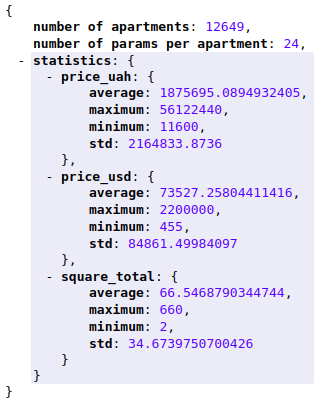

### ML Time

In [8]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

import numpy as np
import torch

In [9]:
X = db[['square_total', 'number_of_rooms', 'floor']]
Y = db['price_usd']

tree_score = np.sqrt(-1*np.mean(cross_val_score(DecisionTreeRegressor(random_state=0), X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_squared_error')))
lr_score = np.sqrt(-1*np.mean(cross_val_score(LinearRegression(), X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_squared_error')))

print(f'SCORES:\n\tDecisionTreeRegressor:  {tree_score}\n\tLinearRegression:  {lr_score}')

SCORES:
	DecisionTreeRegressor:  71187.3452417269
	LinearRegression:  63517.121108358915


In [10]:
new_db = db.drop(columns=['apartment_verified', 'year_of_construction', 'title','number_of_images', 'walls_material', 'street', 'publishing_date','number_of_floors', 'page_url', 'price_uah','price_verified', 'description', 'district_name', 'latitude', 'longitude'])
new_db

,price_usd,square_total,square_living,square_kitchen,number_of_rooms,floor,type_of_sentence,heating,group_city,region_group,street_group,walls_group
item_id,,,,,,,,,,,,
15767616,22500,52.0,26.000000,14.000000,1,4,от хозяина,индивидуальное,0,1,1,3
15866996,21000,47.0,25.000000,10.000000,1,9,от посредника,без отопления,0,2,1,3
15325562,30000,90.0,63.931331,19.712517,2,1,от представителя застройщика,без отопления,0,3,0,1
15829567,35500,50.0,29.800000,8.000000,2,5,от посредника,централизованное,0,2,0,2
15748085,29999,71.5,40.000000,18.000000,2,10,от посредника,без отопления,0,2,1,3
15417126,25500,43.0,23.000000,10.000000,1,3,от посредника,индивидуальное,0,1,1,3
15983954,107000,78.4,34.100000,15.600000,2,17,от хозяина,централизованное,2,3,3,3
15325615,30000,91.0,60.000000,26.500000,3,1,от представителя застройщика,без отопления,0,3,1,1
15539668,74000,70.0,36.000000,18.000000,2,8,от посредника,индивидуальное,0,3,2,3


In [ ]:
lets_try = pd.get_dummies(new_db,columns=['type_of_sentence', 'heating', 'group_city','region_group', 'street_group', 'walls_group'])

X = lets_try.drop(columns='price_usd')
Y = lets_try['price_usd']

In [ ]:
lets_try

In [11]:
tree_score = np.sqrt(-1*np.mean(cross_val_score(DecisionTreeRegressor(random_state=0), X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_squared_error')))
lr_score = np.sqrt(-1*np.mean(cross_val_score(LinearRegression(), X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_squared_error')))

print(f'SCORES:\n\tDecisionTreeRegressor:  {tree_score}\n\tLinearRegression:  {lr_score}')

SCORES:
	DecisionTreeRegressor:  69834.05705219298
	LinearRegression:  56252.980865204954


In [108]:
import xgboost as xgb


xg_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=1000, objective='reg:squarederror' )
print (xg_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [109]:
xgboost_rmse_score = np.sqrt(-1*np.mean(cross_val_score(xg_model, X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_squared_error')))

In [110]:
xgboost_rmse_score

52061.82775737394

In [111]:
xgboost_mae_score = np.mean(-1*cross_val_score(xg_model, X, Y, cv=KFold(10, shuffle=True, random_state=0), scoring='neg_mean_absolute_error'))

In [112]:
xgboost_mae_score

20060.76824195905

In [37]:
def load_data(X_train, X_test, y_train, y_test, device):

    return torch.tensor(X_train.values, dtype=torch.float32, device=device), \
           torch.tensor(X_test.values, dtype=torch.float32, device=device), \
           torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32, device=device), \
           torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32, device=device)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = load_data(X_train, X_test, y_train, y_test, 'cpu')

In [61]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h1_relu = self.linear1(x).clamp(min=0)
        h2_relu = self.linear2(h1_relu).clamp(min=0)
        h3_relu = self.linear3(h2_relu).clamp(min=0)
        y_pred = self.linear4(h3_relu)
        
        return y_pred

losses=[]

D_in, H, D_out = 33, 300, 1
nn_model = TwoLayerNet(D_in, H, D_out)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
for t in range(1500):
    y_pred = nn_model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [62]:
torch.sqrt(torch.nn.MSELoss()(nn_model(X_test), y_test))

tensor(51614.1641, grad_fn=<SqrtBackward>)

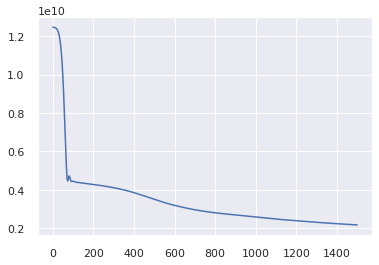

In [107]:
from matplotlib.pyplot import plot

import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [76]:
print(f'\tExample:\n\t\tprediction: {nn_model(X_test[1]).item()},\ttrue: {y_test[1][0]}')

	Example:
		prediction: 50299.6484375,	true: 51000.0
